In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
from copy import deepcopy
import timeit
from random import choice
import time

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from itertools import cycle, islice
from itertools import cycle, islice

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# distance calculator

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


# Gliederung
1. Generation of different datasets
2. Kmeans Algorithm
3. Kmeans++
4. Minibatch kmeans
5. Vergleich own implementation with sctilearn implementation
6. eigene Implementation auf unseren Dateset anwenden
7. Markergenes

# 1. Generation of different datasets

we generated different datasets to test 

In [43]:
n_samples=1000 #Size of Dataset, variable

## Noisy Circles

Text(0.5, 1.0, 'Noisy circle')

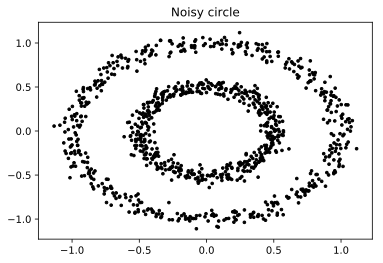

In [44]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
points_noisy_circles=noisy_circles[0]

f1=points_noisy_circles[0:((n_samples)), 0]
f2=points_noisy_circles[0:((n_samples)),1]

plt.scatter(f1, f2, c='black', s=7)
plt.title('Noisy circle')


## Noisy moons

Text(0.5, 1.0, 'Noisy moons')

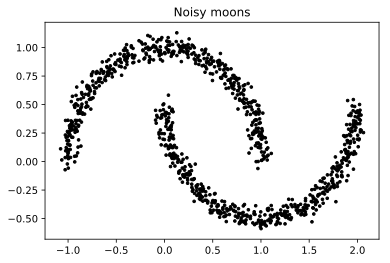

In [45]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
points_noisy_moons=noisy_moons[0]
f1=points_noisy_moons[0:((n_samples)), 0]
f2=points_noisy_moons[0:((n_samples)),1]
plt.scatter(f1, f2, c='black', s=7)
plt.title('Noisy moons')

## No structure

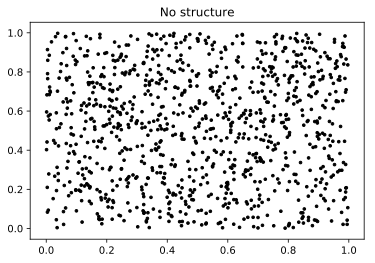

In [46]:
no_structure = np.random.rand(n_samples, 2)
f1=no_structure[0:((n_samples)), 0]
f2=no_structure[0:((n_samples)),1]

plt.title('No structure')
plt.scatter(f1, f2, c='black', s=7) 

## Blobs

Text(0.5, 1.0, 'Blobs')

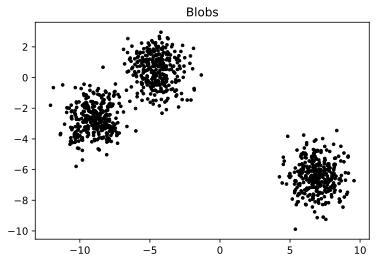

In [47]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=15)
points_blobs=blobs[0]

f1=points_blobs[0:((n_samples)), 0]
f2=points_blobs[0:((n_samples)),1]

plt.scatter(f1, f2, c='black', s=7)
plt.title('Blobs')

in diesem dokument haben wir repräsatativ die blobs ausgewählt da es am meisten mach den zu clustern

In [48]:
X = np.array(list(zip(f1, f2)))

# 2. Kmeans Implementation -> Lloyd-Algorithmus

## Pseudo code
1. Initialization: Choose initial centroids -> choose k samples from the dataset X

    
    Looping between the following steps:


2. Assignment: Each sample is assigned to its nearest center

3. Update the centroids: calculate the mean values of all of the samples assigned to each previous centroid.

   the algorithm repeats these last two steps until there is no difference between the old and the new centroids

## 1. Initialization

1. chossing number of clusers

In [49]:
k=3

2. In order to avoid that no datapoints will be assigned to the initial centroids, we choose some random samples from our dataset

Text(0.5, 1.0, 'Blobs with random centers')

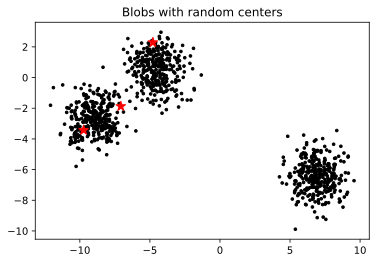

In [50]:
Indecies_centroid = np.random.choice(n_samples,size=k) # for initialization we choose some random datapoint in order to avoid that no data points were assigned to random centroid
    
      
C=X[Indecies_centroid]

plt.scatter(f1,f2,c='black',s=7)
plt.scatter(C[:, 0], C[:, 1],marker='*',c='red',s=100)
plt.title('Blobs with random centers')

## 2. Assignment

1. Distanzen von jedem Sample zu allen Clustern berechnen

In [51]:
for i in range(len(X)):
            distances = dist(C,[X[i]])

2. Minimale Distanz auswählen -> Zuordnung zu diesem Cluster

In [52]:
clusters = np.zeros(len(X)) ## Hier genieren wir einen leeren Array, der dann überschrieben wird in for loop


for i in range(len(X)):
            distances = dist(C,[X[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster

## 3. Update

calculate the mean values of all of the samples assigned to each previous centroid

In [53]:
for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
        
print(C)

[[-1.5515868  -4.02189483]
 [ 0.80057632 -2.24474173]
 [-9.40922418 -2.90366676]]


die letzten zwei Schritte (Assignment und update) so lange wiederholen, bis sich Centroide nicht mehr verändern. daher keine Distanz von C_old zu C (new) 

-> Schlaufe um diese Schritte legen

In [54]:
clusters = np.zeros(len(X))
C_old = np.zeros(C.shape)
update_centroids = dist(C, C_old) # Konvergenz

while update_centroids.all() != 0:
    for i in range(len(X)):
            distances = dist(C,[X[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C) # der alte Wert muss zwischengespeichert werden, damit Veränderung von C_od zu C (new) berrechnet werden kann
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    update_centroids = dist(C, C_old)

Text(0.5, 1.0, 'Blobs clustered with kmeans')

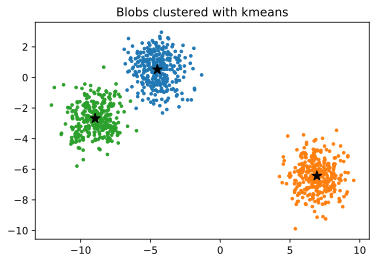

In [55]:
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7)
ax.scatter(C[:, 0], C[:, 1], marker='*', c='black', s=100)
plt.title('Blobs clustered with kmeans')

# K-means ++

   1. Take one center c1, chosen uniformly at random X
   2. Take an new center ci, choosing x e X with probability Dx^2/(summe Dx^2)
   3. Repeat step 2 until we have taken k centers altogether
   4. Proceed as with the standard k-means algorthm

## Step 1

Take one center c1, chosen uniformly at random from X

In [56]:
C2 = np.random.random((1,2))
print(C2)

[[0.82449985 0.27996287]]


## Step 2 and 3:

Take a new center ci choosing xEX with probability (D(x)^2)/(Summe D(x)^2)

D(x) denote the shortest distance from a data point to the closest center we have already chosen

Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2

**Preparation**

In [57]:
# distance calculator

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

#"Kmeans part"    
clusters = np.zeros(len(X))
C_old = np.zeros(C2.shape)
error = dist(C2, C_old) # Konvergenz

#"Kmeans++ part"
data_2 = pd.DataFrame(X)
data_long = data_2.reset_index().melt(id_vars="index") #Index aus Wahrscheinlichkeitsverteilung zur Tabelle hinzufügen
a = np.array(data_long)
index =a[0:n_samples,0] #Index definieren
Liste =[] #Liste für kleinsten Distanzen

In [58]:
print(C2)

[[0.82449985 0.27996287]]


In [59]:
k=3#Anzahl der Cluster festlegen

In [60]:
n=0

while n < k - 1:
    n=n+1
    Liste =[]
    for i in range (len(X)):
        diff=X[i]-C2
        dist = np.linalg.norm(diff,axis=1) # Distance berechnen
        min_dist= np.min(dist)
        Liste.append(min_dist)
    s= np.array(Liste)
    dist_2 = (s)**2
    prob = (dist_2)/ sum (dist_2) #p-Verteilung
    z=np.random.choice(index, p=prob) #Index des neuen Clusters in Tabelle
    c_neu=X[z] #Datenpunkt mit Index z als neues Center festlegen
    cl = np.ndarray.tolist(C2) #alter arry in liste umwandeln damit ein Wert hinzugefügt werden kann
    c_neul = np.ndarray.tolist (c_neu) #neuer Wert in Liste umgewandelt
    cl.append (c_neul) # Center-Liste mit neuen Centerdaten erweitern
    C2 = np.array(cl) #Liste wieder in Array umwandeln
print(C2)

[[ 0.82449985  0.27996287]
 [ 6.8754739  -6.34036566]
 [ 5.87994446 -5.69417203]]


Text(0.5, 1.0, 'Blobs with centers defined by kmeans++ algorithm')

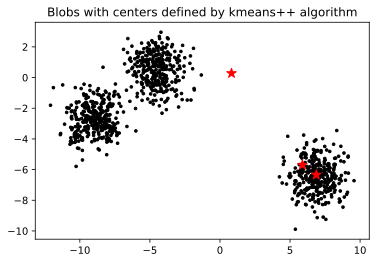

In [61]:
cx1= C2[0:((k)),0]
cy1 = C2[0:((k)),1]

plt.scatter(f1,f2,c='black',s=7)

plt.scatter(cx1,cy1,marker='*',c='red',s=100)
plt.title('Blobs with centers defined by kmeans++ algorithm')

## Step 4

Proceed as with the standard k-means algorthm


In [62]:
while error.all() != 0:
    for i in range(len(X)):
            diff2=X[i]-C2
            distances = np.linalg.norm(diff2,axis=1) # Distance berechnen
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C2)
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C2[i] = np.mean(points, axis=0)
    diff3 = C2-C_old
    error = np.linalg.norm(diff3,axis=1) # Distance berechnen

Text(0.5, 1.0, 'Blobs clustered with kmeans++')

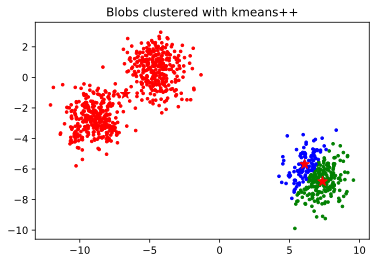

In [63]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
plt.scatter(cx1,cy1,marker='*',c='red',s=100)
plt.title('Blobs clustered with kmeans++')

# Mini-batch implementation

# Vergleich

## Scitlearn implementations

**1. Kmeans**

Text(0.5, 1.0, 'Blobs clustered with scitlearn kmeans')

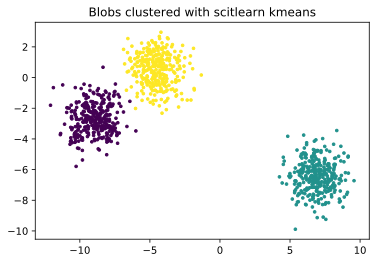

In [64]:
kmeans = KMeans(n_clusters=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans,s=7)
plt.title('Blobs clustered with scitlearn kmeans')

**2. Kmeans++**

Text(0.5, 1.0, 'Blobs clustered with scitlearn kmeans++')

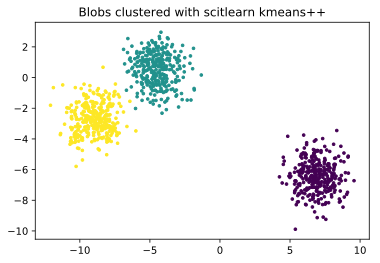

In [65]:
kmeans = KMeans(n_clusters=3,init='k-means++').fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans,s=7)
plt.title('Blobs clustered with scitlearn kmeans++')

**3. Minibatch**

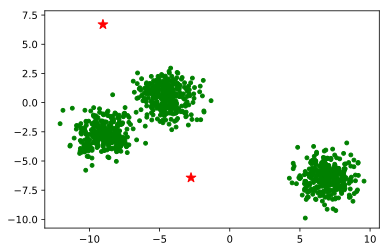

In [66]:
kmeans = MiniBatchKMeans(n_clusters=k, 
                         random_state=0, 
                         batch_size=10,
                        max_iter=4).fit(X)
c3 = kmeans.cluster_centers_[0, :]
c4 = kmeans.cluster_centers_[1, :]

plt.scatter(f1, f2, c='green', s=15)

X = (list(zip(f1, f2)))

plt.scatter(c3, c4, marker='*',c='red',s=100)

den vergleich haben wir jetzt nur repräsentativ für kmeans mit scitlearn gemacht

## 1. Quality

In [67]:
X = np.array(list(zip(f1, f2)))

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

*Own implementation*

In [68]:
k_all=(2,3,5,10) # hier kann man die Anzahl an k, die man vergleichen will, einfach eingeben

WSS_own = np.zeros(4)

for l in range(4):
    k=k_all[l]
    
    times_to_repeat = 10

    sum_WSS = 0
    
    
    for j in range (times_to_repeat):


        start_time = timeit.default_timer()


        Indecies_centroid = np.random.choice(n_samples,size=k) # for initialization we choose some random datapoint in order to avoid that no data points were assigned to random centroid


        C=X[Indecies_centroid]

        clusters = np.zeros(len(X))
        C_old = np.zeros(C.shape)
        error = dist(C, C_old) # Konvergenz
        from copy import deepcopy

        while error.all() != 0:
            for i in range(len(X)):
                    distances = dist(C,[X[i]])
                    cluster = np.argmin(distances)
                    clusters[i] = cluster
            C_old = deepcopy(C)
            for i in range(k):
                points = [X[j] for j in range(len(X)) if clusters[j] == i]
                C[i] = np.mean(points, axis=0)
            error = dist(C, C_old)


        
        WSS=0

        for j in range(len(X)):
        
            WSS += dist(X[j],C[int(clusters[j])], ax = 0)**2
  
        sum_WSS=sum_WSS+WSS
    
    average_WSS= (sum_WSS/times_to_repeat)
    
      
    
    WSS_own[l]=average_WSS
   
    print(WSS_own)
        

[7005.74441489    0.            0.            0.        ]
[7005.74441489 4405.91680762    0.            0.        ]
[7005.74441489 4405.91680762 1620.84786368    0.        ]
[7005.74441489 4405.91680762 1620.84786368  925.66003947]


*Scitlearn implementation*

In [69]:
n_clusters=(2,3,5,10)

WSS_scikit = np.zeros(4)

for l in range(4):

    times_to_repeat = 10

    sum_WSS = 0

    for i in range (times_to_repeat):
        
        

        start_time = timeit.default_timer()

        kmeans = KMeans(n_clusters[l])


        a = kmeans.fit_predict(X)
        kmeans.inertia_
       
        
        sum_WSS=sum_WSS+kmeans.inertia_
    
        average_WSS= sum_WSS/times_to_repeat
    
        WSS_scikit[l]=average_WSS


print(WSS_scikit)

[7005.74441489 2003.38215145 1531.80444108  813.19432316]


*Plot*

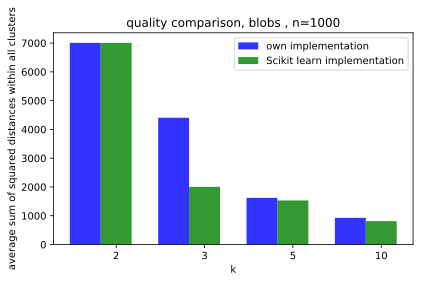

In [70]:
## hab hier alles so angepasst, dass Beschriftungen alle automatisch passen, je nach dem wie man n_samples, k etc verändert hat

# data to plot
n_groups = 4
means_own = (WSS_own)
means_scikit = (WSS_scikit)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_own, bar_width,
alpha=opacity,
color='b',
label='own implementation')

rects2 = plt.bar(index + bar_width, means_scikit, bar_width,
alpha=opacity,
color='g',
label='Scikit learn implementation')

plt.xlabel('k')
plt.ylabel('average sum of squared distances within all clusters')
plt.title('quality comparison, blobs , n=' +  str(n_samples))
plt.xticks(index + bar_width, (k_all))
plt.legend()

plt.tight_layout()
plt.show()

## 2. Runtime

In [71]:
X = np.array(list(zip(f1, f2)))

def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


*Own implementation*

In [72]:
k_all=(2,3,5,10) # hier kann man die Anzahl an k, die man vergleichen will, einfach eingeben

runtime_own = np.zeros(4)

for l in range(4):
    k=k_all[l]
    
    times_to_repeat = 10

    sum_runtime = 0
    
    
    for j in range (times_to_repeat):


        start_time = timeit.default_timer()


        Indecies_centroid = np.random.choice(n_samples,size=k) # for initialization we choose some random datapoint in order to avoid that no data points were assigned to random centroid


        C=X[Indecies_centroid]

        clusters = np.zeros(len(X))
        C_old = np.zeros(C.shape)
        error = dist(C, C_old) # Konvergenz
        from copy import deepcopy

        while error.all() != 0:
            for i in range(len(X)):
                    distances = dist(C,[X[i]])
                    cluster = np.argmin(distances)
                    clusters[i] = cluster
            C_old = deepcopy(C)
            for i in range(k):
                points = [X[j] for j in range(len(X)) if clusters[j] == i]
                C[i] = np.mean(points, axis=0)
            error = dist(C, C_old)


        
        runtime= timeit.default_timer() - start_time
    
        sum_runtime= sum_runtime+runtime
  

    average_runtime= (sum_runtime/times_to_repeat)
    
    
    runtime_own[l]=average_runtime
   
    print(runtime_own)

[0.30729733 0.         0.         0.        ]
[0.30729733 0.31465021 0.         0.        ]
[0.30729733 0.31465021 0.5052828  0.        ]
[0.30729733 0.31465021 0.5052828  0.88283099]


*Scitlearn implementation*

In [73]:
n_clusters=(2,3,5,10)

runtime_scikit = np.zeros(4)

for l in range(4):
    

    times_to_repeat = 10

    sum_runtime = 0

    for i in range (times_to_repeat):


        start_time = timeit.default_timer()

        kmeans = KMeans(n_clusters[l]).fit_predict(X)


        runtime= timeit.default_timer() - start_time
    
        sum_runtime= sum_runtime+runtime
    
    average_runtime= sum_runtime/times_to_repeat
    
    runtime_scikit[l]=average_runtime
   

print(runtime_scikit)

[0.05164706 0.06307175 0.21297118 0.46221605]


*Plot*

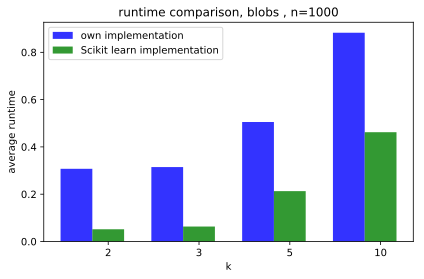

In [74]:
# data to plot
n_groups = 4
means_own = (runtime_own)
means_scikit = (runtime_scikit)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_own, bar_width,
alpha=opacity,
color='b',
label='own implementation')

rects2 = plt.bar(index + bar_width, means_scikit, bar_width,
alpha=opacity,
color='g',
label='Scikit learn implementation')

plt.xlabel('k')
plt.ylabel('average runtime')
plt.title('runtime comparison, blobs , n=' +  str(n_samples))
plt.xticks(index + bar_width, (k_all))
plt.legend()

plt.tight_layout()
plt.show()